# USD MSAAI Deep Learning Module 3 Assignment
Ian Feekes
ifeekes@sandiego.edu
916-333-8371

If this assignment does not find the correct location or meet the expectations, please contact me by one of the means above and I will gratefully and expediently make such corrections. 

Thank you for taking the time to look at my work.


## Initial Configuration
The below few cells will set up the libraries, global variables, and other necessary items before getting into exploratory analysis

In [ ]:
# Import Libraries
import pandas as pd                                   # Allows usage of data frames
from sklearn.preprocessing import MinMaxScaler        # Allows use of minMaxScaler
from matplotlib import pyplot as plt                  # Heatmap plots
import seaborn as sns                                 # More plotting tools
from sklearn.model_selection import train_test_split  # Train Test split the data
from sklearn.neural_network import MLPRegressor       # To Train ANN, MLP regressor used
from sklearn import metrics                           # Import the metrics class

# Begin NEW imports
from matplotlib import pyplot                         # To plot image data
import tensorflow as tf                               # tensorflow used for CNN
from keras.preprocessing.image import ImageDataGenerator # Used for image augmentation
import numpy as np

In [ ]:
# Determine version of Tensorflow and break if we aren't using 2.0 or higher
tf.__version__

assert(int(tf.__version__.split('.')[0]) >= 2)

In [ ]:
# Global variables used for tweaking model
epochs = 5                                           # Initially tested with 25 epochs, and found that at most 5 should be used.
batch_size = 64

### Mounting Drive
In order to run the dataset on a cloud file system the drive must first be mounted. Note that for assignment 3, the keras mnist dataset is avalable on google collabs, and as such will simply be imported here, though the local files are still on my drive in this assignment folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing the dataset
While I have the dataset downloaded locally and to Google Drive, it may be nicest to simply import it as a public resource. Here we do that, load it into training and testing data with the labelled expected values, and break the flow of execution if the data frames don't contain any entries.

In [ ]:
# Import the data object
from keras.datasets import mnist

# Load data into test/training data sets with labels
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Break if the data frame isn't properly imported
assert(train_X.shape[0] > 0 and 
       train_y.shape[0] > 0 and
       test_X.shape[0] > 0 and
       test_y.shape[0] > 0)

### Analyzing Dataset
The below cells perform some basic analysis on the image dataset imported above.

#### Plotting Classes
The below cell shows a distribution plot of the class labels found in the training dataset. There are ten possibilities for the characters that can be classified in a given image.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


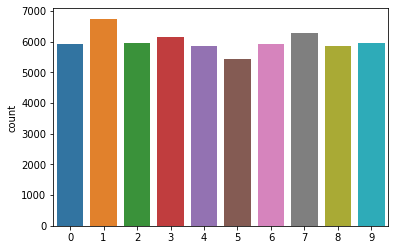

In [ ]:
sns.countplot(train_y)

#### Plotting Training Images
Here we are able to see the first few images in the training dataset. 
https://www.askpython.com/python/examples/load-and-plot-mnist-dataset-in-python

This one seems useful as well https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial/notebook

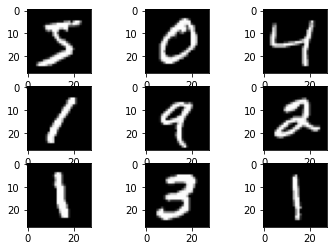

In [ ]:
for i in range(9):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

#### Verifying no null values
The below cell breaks the education of code if there are null values so that the prorgammer knows to go deal with them first.

In [ ]:
assert(np.isnan(train_X).any() == False)
assert(np.isnan(test_X).any() == False)

## Data Preparation
The below few cells will perform some basic transformations for our dataset in order to avoid overfitting. Simple geometrical transofmormations such as zooms, horizontal translation, and image distortion will be applied in order to prevent overfitting. At the same time this parameter is leveraged in order to perform feature scaling. 

### Reshape and Normalize
The below snippet reshapes the training and test image data as the first layer will expect one giant image, not 60,000 little images. It also normalizes the greyscale values.**bold text**

In [ ]:
# Reshape the data
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2], 1)

# Normalize the data
train_X = train_X / 255.0
test_X = test_X / 255.0

### One-Hot Encode
The variables are currently classified in 0-9 values, and we want them to be separated into 10 individual classes. The below snippet does that

In [ ]:
train_y = tf.one_hot(train_y.astype(np.int32), depth=10)
test_y = tf.one_hot(test_y.astype(np.int32), depth=10)

## Building CNN
The CNN is still a sequence of layers, but with convolution and pooling applied (twice) before fed into the ANN structure.

NameError: ignored

In [ ]:
# Initialize the CNN, which is a sequence of layers ergo usage of Sequential class - the same class that would be used for an ANN
cnn = tf.keras.models.Sequential()

In [ ]:
input_shape = (28, 28, 1)

# Add the first convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters = 32,                # 32 feature detectors applied to image
                               kernel_size = 3,             # Size of feature detector is 3x3 matrix, but other sizes and feature detectors can be used. Possibly use a larger kernel size for our first layer
                               activation = 'relu',         # Relu activation funection used
                               input_shape = input_shape))  # 64 x 64 x 3 image dimensions, but with greyscale it could be 64 x 64 x 1

In [ ]:
# Add the first pooling layer. Max Pooling sources highest pixel value in each frame
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2,           # Size of pooling operation must always be smaller than feature map. Almost always 2x2
                                  strides = 2))            # Stride of pooling operation

In [ ]:
# Add next series of convolutional and pooling layers
cnn.add(tf.keras.layers.Conv2D(filters = 32,               # Could potentially do 64? 
                               kernel_size = 3,
                               activation = 'relu'))

cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2,
                                  strides = 2))

In [ ]:
# Add a flattening layer to effectively created a 1D layers that serves to the fully-connected ANN
cnn.add(tf.keras.layers.Flatten())

In [ ]:
# Add a fully-connected neural network
cnn.add(tf.keras.layers.Dense(units = 128,                 # 128 hidden layers. We can experiment with this number
                              activation = 'relu'))        # ReLu activation function is used

In [ ]:
# Add the output layer
cnn.add(tf.keras.layers.Dense(units = 10,                  # 10 different digits
                              activation = 'softmax'))     # Softmax used for multi-class classification

In [ ]:
# Compile the CNN
cnn.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08),
            loss='categorical_crossentropy',                      # Use loss function of categorical cross-entropy 
            metrics=['accuracy'])                                 # For now just regular accuracy of predicting correct label

In [ ]:
# Fit the CNN
history = cnn.fit(train_X,
                  train_y,
                  batch_size=batch_size,
                  epochs=epochs,                                 
                  validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 38s 44ms/step - loss: 0.1900 - accuracy: 0.9428 - val_loss: 0.0786 - val_accuracy: 0.9758
Epoch 2/5
844/844 [==============================] - 37s 44ms/step - loss: 0.0551 - accuracy: 0.9829 - val_loss: 0.0377 - val_accuracy: 0.9895
Epoch 3/5
844/844 [==============================] - 36s 43ms/step - loss: 0.0377 - accuracy: 0.9882 - val_loss: 0.0363 - val_accuracy: 0.9898
Epoch 4/5
844/844 [==============================] - 38s 45ms/step - loss: 0.0289 - accuracy: 0.9912 - val_loss: 0.0365 - val_accuracy: 0.9895
Epoch 5/5
844/844 [==============================] - 36s 43ms/step - loss: 0.0223 - accuracy: 0.9929 - val_loss: 0.0406 - val_accuracy: 0.9903


## Model Evaluation

### Plotting Training and Validation Accuracy and Loss
The below snippet plots the accuracy and loss of our model through the epochs

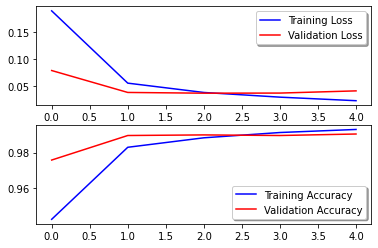

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Evaluating Model Accuracy
The below snippet determines the accuracy of the model

In [ ]:
test_loss, test_acc = cnn.evaluate(test_X, test_y)


313/313 [==============================] - 3s 9ms/step - loss: 0.0360 - accuracy: 0.9894


### Generating Confusion Matrix

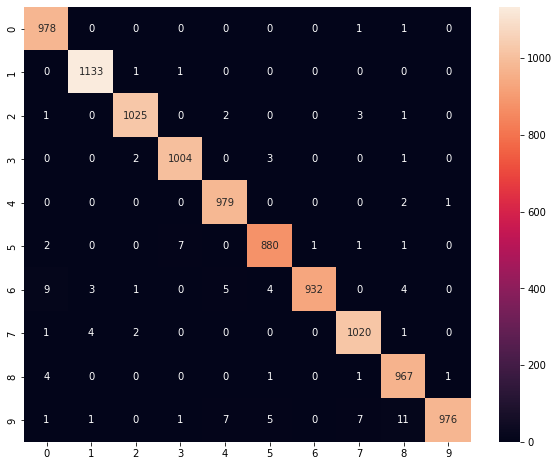

In [ ]:
# Predict the values from the testing dataset
Y_pred = cnn.predict(test_X)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(test_y, axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

## Findings

### Models Evaluated


#### Model 1: Baseline 

The baseline model was a CNN with two convolution/pooling layers. Both convolutional layers had 32 features and kernel sizes of 3. Both pooling layers had pool sizes of 2 and strides of 2. This model was trained under 25 epochs, largely with the intention of initially determining the optimal number of epochs train latter models with. 

The baseline model was compiled with an RMS prop optimization function. This optimization function was chosen for similar behavior to gradient descent, but for learning rate oscillation for faster convergence. 

The loss function of the baseline model was categorical cross-entropy since this is a non-binary classifier.

Accuracy was the chosen metric. 



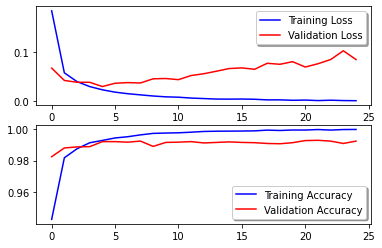

The model performed with an accuracy of **99.14%** and a loss of **.0692**, however it was highly subject to overfitting. As seen by the confusion matrix plotted below, the baseline model had a lot of trouble confusing 4's and 9's, 2's and 7's, 3's and 5's, and 2's and 8's. All of these seem intuitively understandable decisions due to similar features exibited by each of these characters.

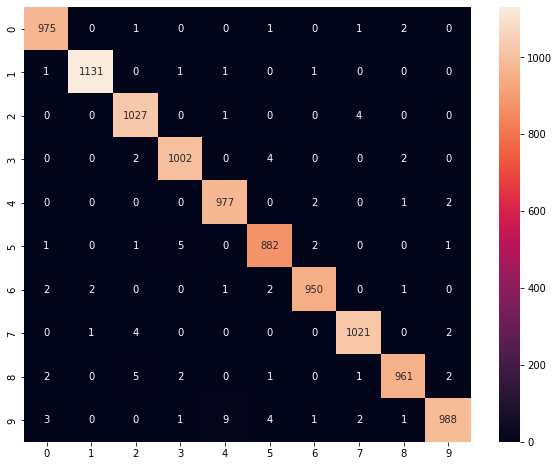

#### Model 2: 5 Epoch Baseline

This CNN exibited the very same configurations as the baseline, but with only 5 epochs set to limit training time and to reduce overfitting.

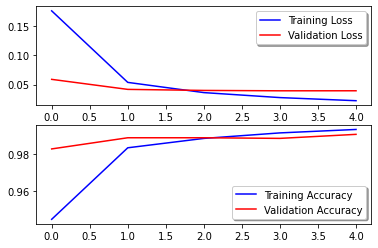

The lower epoch model produced barely any diminished accuracy at **99.03%** and a los of **.0319**, the loss being significantly lower then the baseline model.


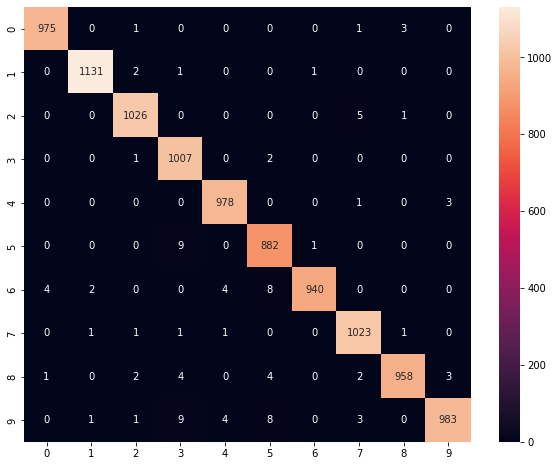

The confusion matrix also exibits similarities with the basline mis-classifications. 5's and 3's remained a significant problem, as did 5's and 9's. 2's and 7's, 4's and 9's, 4's and 6's, and 0's and 8's all had some trouble. 

Interestingly, this model had less trouble with mis-classifying 2's as the baseline did, but had some real problems with misclassifying 9's. 

#### Model 3: Larger kernel, smaller initial pooling stride

This model differs from the baseline in having only 5 epochs for training, and in the first set of convolutional pooling layers. The first convolutional layer uses a kernel size of 5x5 (rather than 3x3) and the first pooling layer uses a stride of only 1 rather than 2. This is so that the first layer is less distorted in hopes of having less mis-classified 9's and 3's. 

The training time for this model was notably more significant than the first two models due to many more matrix operations being performed during the first and second layers.

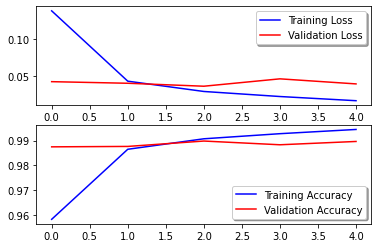

This model produced an accuracy of **99.13%** and a loss of **.0345**, having slightly more accuracy than the epoch baseline, but a tradeoff of more loss.

The model had the most trouble misclassifying 7's and 2's and 5's and 3's while having less trouble with 9's than the epoch baseline model. This could be attributed to the larger kernel size being able to pick out more circular features nuanced within digits (4,s 3's, 7,s) similar to 9s. 

### Best Number of Epochs is 4-5


Epochs were initially set to 25 on the baseline model. The loss and accuracy curves of training and validation are plotted below. As the number of epochs increases beyond 4, validation loss starts increasing while training loss becomes nearly 0. This shows that the model is beginning to overfit and it is best to limit our epochs to 4. 

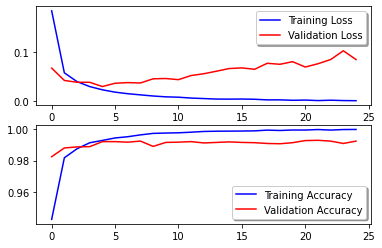